# Random Forest Analysis

## Setup

In [141]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [142]:
# Load data
data = pd.read_csv('data/ames_rf.csv')

In [143]:
# Create the independent variables and the target
predictors = data.drop('SalePrice', axis=1)
target = data['SalePrice']

In [144]:
# Check columns
column_names = predictors.columns
for column in column_names:
    print(column)

GrLivArea
LotFrontage
LotArea
OverallQual
OverallCond
MasVnrArea
ExterQual
ExterCond
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
YearsSinceBuilt
YearsSinceRemod
Crisis
MSZoning_C (all)
MSZoning_FV
MSZoning_I (all)
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Pave
Alley_None
Alley_Pave
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_HLS
LandContour_Low
LandContour_Lvl
Utilities_NoSewr
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Greens
Neighborhood_GrnHill
Neighborhood_IDOTRR
Neighborhood_Landmrk
Neighborhood_MeadowV
Ne

In [145]:
# Check info on predictors
print(predictors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2576 entries, 0 to 2575
Columns: 278 entries, GrLivArea to MSSubClass_90
dtypes: float64(11), int64(267)
memory usage: 5.5 MB
None


In [146]:
# View data
predictors.head()

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,856,0.0,7890,6,6,0.0,3,3,238.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1049,42.0,4235,5,5,149.0,4,3,552.0,393.0,...,0,0,0,0,0,0,0,0,0,0
2,1001,60.0,6060,5,9,0.0,4,3,737.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,1039,80.0,8146,4,8,0.0,4,4,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,1665,70.0,8400,8,6,0.0,4,3,643.0,0.0,...,0,0,0,0,1,0,0,0,0,0


## Perform Train-Test Split

In [147]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=0, test_size = 0.2)

In [148]:
# Check training set features and target
print(X_train.shape)
print(y_train.shape)

(2060, 278)
(2060,)


In [149]:
# Check test set features and target
print(X_test.shape)
print(y_test.shape)

(516, 278)
(516,)


## Data Prep for Train Set

In [158]:
# Transform Train Set target using log transformation
y_train = np.log(y_train)

## Data Prep for Test Set

In [159]:
# Transform Test Set target using log transformation
y_test = np.log(y_test)

## Train Model

In [160]:
# Initialize a random forest regressor with replacement
rf = ensemble.RandomForestRegressor(random_state=0, bootstrap=True)

In [161]:
# Define the parameter grid
param_dist = {
    'n_estimators': [10, 100, 500, 1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20]
}

In [162]:
# Initialize the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_dist, 
                           cv=5,
                           scoring='r2',
                           n_jobs = -1,
                           verbose = 1)

In [163]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [10, 100, 500, 1000]},
             scoring='r2', verbose=1)

In [164]:
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}


## Evaluate Model

In [165]:
# Use the best parameters
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=1000, random_state=0)

In [166]:
# Predict the train set
y_pred_train = rf_best.predict(X_train)

# Calculate and print the metrics for Train
r2_train = r2_score(y_train, y_pred_train)
print("Train R2 Score: ", r2_train)

Train R2 Score:  0.955504669208558


In [167]:
# Predict the test set
y_pred_test = rf_best.predict(X_test)

# Calculate and print the metrics for Test
r2_test = r2_score(y_test, y_pred_test)
print("Test R2 Score: ", r2_test)

Test R2 Score:  0.9004614386818446


## Feature Importances

In [168]:
# Top 5 features
importances = rf_best.feature_importances_
feature_importances = pd.DataFrame({'Feature': predictors.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(5))

        Feature  Importance
3   OverallQual    0.566161
0     GrLivArea    0.108083
25   GarageArea    0.068658
11  TotalBsmtSF    0.047078
12     1stFlrSF    0.041544


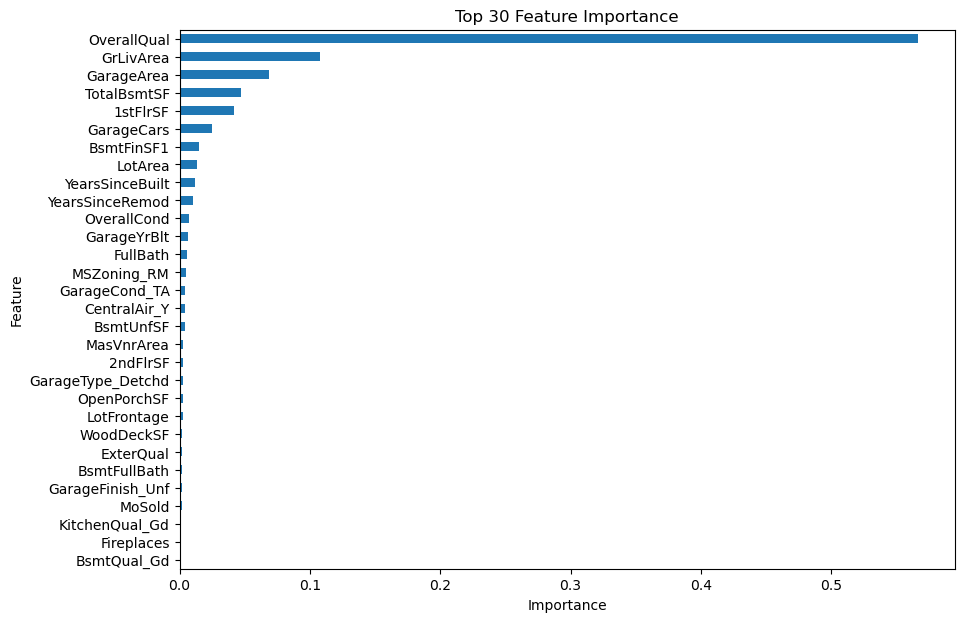

In [169]:
# Get the top 30 features
feature_importances_top_30 = feature_importances.head(30)

# Plot the bar chart
feature_importances_top_30.set_index('Feature')['Importance'].sort_values().plot(kind='barh', figsize=(10, 7))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')
plt.show()


In [96]:
# Count and show the number of features with importance of 0
print("Number of features with importance of 0: ", len(feature_importances[feature_importances['Importance'] == 0]))

Number of features with importance of 0:  95


## Train Model with Only Top 20 Features

In [170]:
# Get list of top 20 features
top_20_features = feature_importances['Feature'][:20].tolist()

In [171]:
# Split the data into training and test sets and select top 20 features
X_train_top_20 = X_train[top_20_features]
X_test_top_20 = X_test[top_20_features]

# Check training set and test set
print("TRAINING SET: \n", X_train_top_20.head())
print("\n"*3)
print("TESTING SET: \n", X_test_top_20.head())

TRAINING SET: 
       OverallQual  GrLivArea  GarageArea  TotalBsmtSF  1stFlrSF  GarageCars  \
1138            7       1792       564.0        963.0       963         2.0   
411             5        864       732.0        864.0       864         2.0   
2301            6       1595       528.0        663.0       774         2.0   
1697            7       1692       513.0        878.0       892         2.0   
1347            9       1720       846.0       1720.0      1720         3.0   

      BsmtFinSF1  LotArea  YearsSinceBuilt  YearsSinceRemod  OverallCond  \
1138       361.0    12435                9                9            5   
411        660.0     8499               49               49            6   
2301       338.0     7200               95               60            8   
1697       353.0     9337               13               12            5   
1347      1104.0    10816                2                2            5   

      GarageYrBlt  FullBath  MSZoning_RM  GarageCond

In [172]:
# Initialize a random forest regressor with replacement
rf_top_20 = ensemble.RandomForestRegressor(random_state=0, bootstrap=True)

In [173]:
# Initialize the grid search model
grid_search_top_20 = GridSearchCV(estimator = rf_top_20,
                           param_grid = param_dist, 
                           cv=5,
                           scoring='r2',
                           n_jobs = -1,
                           verbose = 1)

In [174]:
# Fit the grid search to the data
grid_search_top_20.fit(X_train_top_20, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [10, 100, 500, 1000]},
             scoring='r2', verbose=1)

In [175]:
# Get the best parameters
best_params_top_20 = grid_search_top_20.best_params_
print(best_params_top_20)

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}


In [176]:
# Use the best parameters
rf_best_top_20 = grid_search_top_20.best_estimator_
rf_best_top_20.fit(X_train_top_20, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=500, random_state=0)

In [178]:
# Predict the train set
y_pred_train_top_20 = rf_best_top_20.predict(X_train_top_20)

# Calculate and print the metrics for Train
r2_train_top_20 = r2_score(y_train, y_pred_train_top_20)
print("Train R2 Score: ", r2_train_top_20)

Train R2 Score:  0.9376140050318732


In [179]:
# Predict the test set
y_pred_test_top_20 = rf_best_top_20.predict(X_test_top_20)

# Calculate and print the metrics for Test
r2_test_top_20 = r2_score(y_test, y_pred_test_top_20)
print("Test R2 Score: ", r2_test_top_20)

Test R2 Score:  0.9009232637796099


In [181]:
# Top 5 features
importances = rf_best_top_20.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train_top_20.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(5))

           Feature  Importance
0      OverallQual    0.199337
1        GrLivArea    0.141490
8  YearsSinceBuilt    0.099253
5       GarageCars    0.076532
3      TotalBsmtSF    0.073292
